# Multi-Period Optimal Power Flow
This notebook is inspired by Chapter 6 of the following book:<br>
Soroudi, Alireza. Power system optimization modeling in GAMS. Vol. 78. Berlin/Heidelberg, Germany: Springer, 2017.

In [1]:
from pyomo.environ import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

**Problem Description:**<br>
Optimal Power Flow (OPF) is an optimization problem where the goal is to find steady state operating conditions for power plants connected to a transmission network, while meeting demands and minimizing opeartional costs. We will start with a single period DC power flow problem, and gradually add more complexity to the problem.

# 1. Single Period Optimal DC Power Flow
For a two-bus power network as shown in the figure, the optimization problem is as characterized as follows:<br>
**Mathematical representation:**<br>
$$
\underset{P_{g}, \delta_{i}}{min} \; OF = \sum_{g_{1},g_{2}}^{} a_{g}P_{g}^{2} + b_{g}P_{g} + c_{g}
$$
$$
P_{ij} = \frac {\delta_{1}-\delta_{2}} {X_{12}}
$$

$$
P_{g1} = P_{12}
$$
$$
P_{g2} + P_{12} = L_{2}
$$
$$
-P_{12}^{max} \le P_{12} \le P_{12}^{max}
$$
$$
\delta_{1} = 0 \; Slack
$$
Other parameters related to this DC-OPF are as follows:<br>
$L_{2} = 400 MW$<br>
$X_{12} = 0.2 pu$<br>
$P_{12}^{max} = 1.5 pu$<br>
And the characteristics of the two thermal generators are provided in the following table:

In [2]:
dc_df = pd.DataFrame()
dc_df["g"] = ["g1", "g2"]
dc_df["$a_{g}$"] = [3., 4.05]
dc_df["$b_{g}$"] = [20., 18.07]
dc_df["$c_{g}$"] = [100, 98.87]
dc_df["$P_{min}$"] = [28, 90]
dc_df["$P_{max}$"] = [206, 284]

dc_df

,g,$a_{g}$,$b_{g}$,$c_{g}$,$P_{min}$,$P_{max}$
0,g1,3.00,20.00,100.00,28,206
1,g2,4.05,18.07,98.87,90,284


In [3]:
model = ConcreteModel()

#Indices
model.g = RangeSet(len(dc_df))

#Parameters
def cost_a(model, g):
    return dc_df.loc[g-1,"$a_{g}$"]
model.a = Param(model.g, initialize=cost_a, within=Reals)

def cost_b(model, g):
    return dc_df.loc[g-1,"$b_{g}$"]
model.b = Param(model.g, initialize=cost_b, within=Reals)

def cost_c(model, g):
    return dc_df.loc[g-1,"$c_{g}$"]
model.c = Param(model.g, initialize=cost_c, within=Reals)

def P_min_df(model, g):
    return dc_df.loc[g-1,"$P_{min}$"]
model.P_min = Param(model.g, initialize=P_min_df, within=Reals)

def P_max_df(model, g):
    return dc_df.loc[g-1,"$P_{max}$"]
model.P_max = Param(model.g, initialize=P_max_df, within=Reals)

model.L2 = Param(initialize=400, within=Reals)
model.X12 = Param(initialize=0.2, within=Reals)
model.Pmax12 = Param(initialize=1.50, within=Reals)
model.Sbase = Param(initialize=100, within=Reals)

#Variables
model.P = Var(model.g, within=NonNegativeReals)
model.P12 = Var(within=Reals)
model.delta = Var(model.g, within=Reals)

#Constraints
def min_generation(model, g):
    return  model.P[g] >= model.P_min[g] / model.Sbase
model.c_min_generation = Constraint(model.g, rule=min_generation)

def max_generation(model, g):
    return  model.P[g] <= model.P_max[g] / model.Sbase
model.c_max_generation = Constraint(model.g, rule=max_generation)

def reactance(model):
    return  model.P12 == (model.delta[1] - model.delta[2]) / model.X12
model.c_reactance = Constraint(rule=reactance)

def bus1(model):
    return  model.P[1] == model.P12
model.c_bus1 = Constraint(rule=bus1)

def bus2(model):
    return  model.P[2] + model.P12 == model.L2 / model.Sbase
model.c_bus2 = Constraint(rule=bus2)

def slack(model):
    return  model.delta[1] == 0
model.c_slack = Constraint(rule=slack)

def edge(model):
    return  model.P12 >= model.Pmax12 * (-1)
model.c_edge = Constraint(rule=edge)

def edge2(model):
    return  model.P12 <= model.Pmax12
model.c_edge2 = Constraint(rule=edge2)

#Objective Function
def rule_OF(model):
    return sum(model.a[g]*model.P[g]**2 + model.b[g]*model.P[g] + model.c[g] for g in model.g)
model.objective = Objective(rule=rule_OF, sense=minimize)

opt = SolverFactory('ipopt')

In [4]:
results = opt.solve(model)

print("Total operating cost is $", value(model.objective))

Total operating cost is $ 306.1074998627072


# 1.1 Three-Bus Network DC-OPF
The general form of DC-OPF with multiple buses can be denoted as follows:<br>
**Mathematical representation:**<br>
$$
\underset{P_{g}, \delta_{i}}{min} \; OF = \sum_{g \in \Omega_{G}}^{} a_{g}P_{g}^{2} + b_{g}P_{g} + c_{g}
$$
$$
P_{ij} = \frac {\delta_{i}-\delta_{j}} {X_{ij}} \; \; ij \in \Omega_{l}
$$

$$
\sum_{g \in \Omega_{G}^{i}}^{} P_{g} - L_{i} = \sum_{j \in \Omega_{l}^{i}}^{} P_{ij} : \lambda_{i} \; \; i \in \Omega_{B}
$$
$$
-P_{ij}^{max} \le P_{ij} \le P_{ij}^{max} \; \; ij \in \Omega_{l}
$$
$$
P_{g}^{min} \le P_{g} \le P_{g}^{max}
$$
For a three-bus network shown in the following figure, the characteristics of the two thermal generators and the network are provided in the following table:

In [5]:
bus_df3 = pd.DataFrame()
bus_df3["bus"] = ["bus1", "bus2", "bus3"]
bus_df3["g"] = [[1], [], [3]]
bus_df3["demands"] = [0,100,0]
bus_df3["connectivity"] = [[1,2],[0,2],[0,1]]
bus_df3["x"] = [[1e10,0.2,0.4],[0.2,1e10,0.25],[0.4,0.25,1e10]]
bus_df3["limit"] = [[0,100,100],[100,0,100],[100,100,0]]
bus_df3["$b_{g}$"] = [10., 0.,  11.]
bus_df3["$P_{min}$"] = [0., 0., 0.]
bus_df3["$P_{max}$"] = [65., 0., 100.]
bus_df3

,bus,g,demands,connectivity,x,limit,$b_{g}$,$P_{min}$,$P_{max}$
0,bus1,[1],0,"[1, 2]","[10000000000.0, 0.2, 0.4]","[0, 100, 100]",10.0,0.0,65.0
1,bus2,[],100,"[0, 2]","[0.2, 10000000000.0, 0.25]","[100, 0, 100]",0.0,0.0,0.0
2,bus3,[3],0,"[0, 1]","[0.4, 0.25, 10000000000.0]","[100, 100, 0]",11.0,0.0,100.0


In [6]:
gen_df3 = pd.DataFrame()
gen_df3["Gen"] = ["g1", "g2", "g3"]
gen_df3["$b_{g}$"] = [10., 0.,  11.]
gen_df3["$P_{min}$"] = [0., 0., 0.]
gen_df3["$P_{max}$"] = [65., 0., 100.]

gen_df3.head()

,Gen,$b_{g}$,$P_{min}$,$P_{max}$
0,g1,10.0,0.0,65.0
1,g2,0.0,0.0,0.0
2,g3,11.0,0.0,100.0


In [7]:
def build_model(**kwargs):
    
    model = ConcreteModel()
    
    #Indices
    model.b = RangeSet(kwargs["numbus"])
    model.bb = RangeSet(kwargs["numbus"])
    model.g = RangeSet(kwargs["numgen"])
    
    #Parameters
    def omega_values(model, b):
        return kwargs["omega"][b-1]
    model.omega = Param(model.b, initialize=omega_values, within=Any)
    
    def cost_b(model, g):
        return kwargs["bg"][g-1]
    model.bg = Param(model.g, initialize=cost_b, within=Reals)
    
    def P_min_df(model, g):
        return kwargs["P_min"][g-1]
    model.P_min = Param(model.g, initialize=P_min_df, within=Reals)
    
    def P_max_df(model, g):
        return kwargs["P_max"][g-1]
    model.P_max = Param(model.g, initialize=P_max_df, within=Reals)
    
    def demand_df(model, b):
        return kwargs["demands"][b-1]
    model.L = Param(model.b, initialize=demand_df, within=Reals, mutable=True)
    
    def reactance_df(model, b, bb):
        return kwargs["x"][b-1][bb-1]
    model.X = Param(model.b, model.bb, initialize=reactance_df, within=Reals)
    
    def edge_limit_df(model, b, bb):
        return kwargs["limit"][b-1][bb-1]
    model.edge_limit = Param(model.b, model.bb, initialize=edge_limit_df, within=Reals, mutable=True)
    
    model.Sbase = Param(initialize=kwargs["Sbase"], within=Reals)
    
    #Variables
    model.Pg = Var(model.g, within=NonNegativeReals)
    model.P = Var(model.b, model.bb, within=Reals)
    model.delta = Var(model.b, within=Reals)
    
    #Constraints
    def min_generation(model, g):
        return  model.Pg[g] >= model.P_min[g] / model.Sbase
    model.c_min_generation = Constraint(model.g, rule=min_generation)

    def max_generation(model, g):
        return  model.Pg[g] <= model.P_max[g] / model.Sbase
    model.c_max_generation = Constraint(model.g, rule=max_generation)

    def p_reactance(model, b, bb):
        return  model.P[b,bb] == (model.delta[b] - model.delta[bb]) / model.X[b,bb]
    model.c_p_reactance = Constraint(model.b, model.bb, rule=p_reactance)
    
    def slack_bus_angle(model):
        return  model.delta[kwargs["slack_bus"]] == 0
    model.c_slack_bus_angle = Constraint(rule=slack_bus_angle)

    def edge_lo_limit(model, b, bb):
        return  model.P[b,bb] >= (model.edge_limit[b,bb] / model.Sbase) * (-1)
    model.c_edge_lo_limit = Constraint(model.b, model.bb, rule=edge_lo_limit)

    def edge_hi_limit(model, b, bb):
        return  model.P[b,bb] <= model.edge_limit[b,bb] / model.Sbase
    model.c_edge_hi_limit = Constraint(model.b, model.bb, rule=edge_hi_limit)

    def bus_balance(model,b):
        return  model.L[b] /  model.Sbase == (sum(model.P[b,bb] for bb in model.bb) + sum(model.Pg[f] for f in model.omega[b]))
    model.c_bus_balance = Constraint(model.b, rule=bus_balance)
    
    #Objective Function
    def rule_OF(model):
        return sum(model.bg[g]*model.Pg[g]*model.Sbase for g in model.g)
    model.objective = Objective(rule=rule_OF, sense=minimize)
    
    return model

In [8]:
del model

model = build_model(numbus=len(bus_df3), numgen=len(gen_df3), omega=bus_df3["g"], bg=gen_df3["$b_{g}$"], P_min=gen_df3["$P_{min}$"], P_max=gen_df3["$P_{max}$"], 
                   demands=bus_df3["demands"], x=bus_df3["x"], limit=bus_df3["limit"], Sbase=100, slack_bus=3)
opt = SolverFactory('ipopt')

results = opt.solve(model)

print("Total operating cost is $", value(model.objective))

Total operating cost is $ 1034.9999990275692


In [9]:
results_df = pd.DataFrame()
results_df["Bus"] = [b for b in model.b]
results_df["P_g (MW)"] = [round(value(model.Pg[b]) * value(model.Sbase), 1) for b in model.b]
results_df["delta (rad)"] = [round(value(model.delta[b]), 2) for b in model.b]
results_df["L (MW)"] = [value(model.L[b]) for b in model.b]
results_df["LMP ($/MWh)"] = np.nan

**LMP:**<br>
LMP at each node is defined as follows:<br>
If the demand at a node is increased by 1MW, how much does the cost at that node increse in terms of $/h.

In [10]:
old_cost = value(model.objective)
for b in model.b:
    model.L[b] += 1
    results = opt.solve(model)
    new_cost = value(model.objective)
    results_df.loc[b-1,["LMP ($/MWh)"]] = new_cost-old_cost
    model.L[b] -= 1
    
results_df

,Bus,P_g (MW),delta (rad),L (MW),LMP ($/MWh)
0,1,65.0,-0.02,0,11.0
1,2,0.0,0.10,100,11.0
2,3,35.0,0.00,0,11.0


# 1.2 Five-Bus Network DC-OPF
Similar to a 3-Bus network, we can solve the DC-OPF for a 5-Bus network. Consider the following table:

In [11]:
bus_df5 = pd.DataFrame()
bus_df5["bus"] = ["bus1", "bus2", "bus3", "bus4", "bus5"]
bus_df5["g"] = [[1,2], [],[3], [4], [5]]
bus_df5["demands"] = [0, 300, 300, 400, 0]
bus_df5["connectivity"] = [["bus2","bus4","bus5"],["bus1","bus3"],["bus2","bus4"],["bus1","bus3","bus5"],["bus1","bus4"]]
bus_df5["x"] = [[1e10,0.0281,1e10,0.0304,0.0064],[0.0281,1e10,0.0108,1e10,1e10],[1e10,0.0108,1e10,0.0297,1e10], \
                [0.0304,1e10,0.0297,1e10,0.0297],[0.0064,1e10,1e10,0.0297,1e10]]
bus_df5["limit"] = [[0,400,0,400,400],[400,0,400,0,0],[0,400,0,400,0],[400,0,400,0,240],[400,0,0,240,0]]
bus_df5

,bus,g,demands,connectivity,x,limit
0,bus1,"[1, 2]",0,"[bus2, bus4, bus5]","[10000000000.0, 0.0281, 10000000000.0, 0.0304,...","[0, 400, 0, 400, 400]"
1,bus2,[],300,"[bus1, bus3]","[0.0281, 10000000000.0, 0.0108, 10000000000.0,...","[400, 0, 400, 0, 0]"
2,bus3,[3],300,"[bus2, bus4]","[10000000000.0, 0.0108, 10000000000.0, 0.0297,...","[0, 400, 0, 400, 0]"
3,bus4,[4],400,"[bus1, bus3, bus5]","[0.0304, 10000000000.0, 0.0297, 10000000000.0,...","[400, 0, 400, 0, 240]"
4,bus5,[5],0,"[bus1, bus4]","[0.0064, 10000000000.0, 10000000000.0, 0.0297,...","[400, 0, 0, 240, 0]"


In [12]:
gen_df5 = pd.DataFrame()
gen_df5["Gen"] = ["g1", "g2", "g3", "g4", "g5"]
gen_df5["$b_{g}$"] = [14., 15.,  30., 40., 10.]
gen_df5["$P_{min}$"] = [0., 0., 0., 0., 0.]
gen_df5["$P_{max}$"] = [40., 170., 520., 200., 600.]

gen_df5

,Gen,$b_{g}$,$P_{min}$,$P_{max}$
0,g1,14.0,0.0,40.0
1,g2,15.0,0.0,170.0
2,g3,30.0,0.0,520.0
3,g4,40.0,0.0,200.0
4,g5,10.0,0.0,600.0


In [13]:
model = build_model(numbus=len(bus_df5), numgen=len(gen_df5), omega=bus_df5["g"], bg=gen_df5["$b_{g}$"], P_min=gen_df5["$P_{min}$"], P_max=gen_df5["$P_{max}$"], 
                   demands=bus_df5["demands"], x=bus_df5["x"], limit=bus_df5["limit"], Sbase=100, slack_bus=1)
opt = SolverFactory('ipopt')

results = opt.solve(model)

print("Total operating cost is $", value(model.objective))

Total operating cost is $ 17479.896770000996


In [14]:
results_df5 = pd.DataFrame()
results_df5["Bus"] = [b for b in model.b]
results_df5["P_g (MW)"] = [[round(value(model.Pg[f]) * value(model.Sbase), 1) for f in bus_df5["g"][b-1]] for b in model.b]
results_df5["delta (rad)"] = [round(value(model.delta[b]), 2) for b in model.b]
results_df5["L (MW)"] = [value(model.L[b]) for b in model.b]
results_df5["LMP ($/MWh)"] = np.nan

In [15]:
old_cost = value(model.objective)
for b in model.b:
    model.L[b] += 1
    results = opt.solve(model)
    new_cost = value(model.objective)
    results_df5.loc[b-1,["LMP ($/MWh)"]] = round(new_cost-old_cost,1)
    model.L[b] -= 1
    
results_df5

,Bus,P_g (MW),delta (rad),L (MW),LMP ($/MWh)
0,1,"[40.0, 170.0]",-0.00,0,17.0
1,2,[],0.07,300,26.4
2,3,[323.5],0.06,300,30.0
3,4,[0.0],0.06,400,39.9
4,5,[466.5],-0.01,0,10.0


# 1.3 IEEE Reliability Test System (RTS) 24-bus network
The RTS 24-bus network is shown below, wit hthe slack bus being bus 13 and Sbase being 100 MVA. The specifications of the network are provided in the following tables:

In [16]:
bus_df24 = pd.DataFrame()
bus_df24["bus"] = ["bus1", "bus2", "bus3", "bus4", "bus5", "bus6", "bus7", "bus8", "bus9", \
                  "bus10", "bus11", "bus12", "bus13", "bus14", "bus15", "bus16", "bus17", \
                  "bus18", "bus19", "bus20", "bus21", "bus22", "bus23", "bus24"]
bus_df24["g"] = [[3], [4], [], [], [], [], [9], [], [], [], [], [], [10], [], [5,11], [6], \
                [], [1], [], [], [2], [12], [7,8], []]
bus_df24["demands"] = [108, 97, 180, 74, 71, 136, 125, 171, 175, 195, 0, 0, 265, 194, 317, \
                      100, 0, 333, 181, 128, 0, 0, 0, 0]
# bus_df24["connectivity"] = [["bus2","bus3","bus5"],["bus1","bus3"],["bus2","bus4"],["bus1","bus3","bus5"],["bus1","bus4"]]
bus_df24["x"] = [[1e10,0.0139,0.2112,1e10,0.0845,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10], \
                    [0.0139,1e10,1e10,0.1267,1e10,0.1920,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10], \
                    [0.2112,1e10,1e10,1e10,1e10,1e10,1e10,1e10,0.1190,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,0.0839], \
                    [1e10,0.1267,1e10,1e10,1e10,1e10,1e10,1e10,0.1037,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10], \
                    [0.0845,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,0.0883,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10], \
                    [1e10,0.1920,1e10,1e10,1e10,1e10,1e10,1e10,1e10,0.0605,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10], \
                    [1e10,1e10,1e10,1e10,1e10,1e10,1e10,0.0614,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10], \
                    [1e10,1e10,1e10,1e10,1e10,1e10,0.0614,1e10,0.1651,0.1651,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10], \
                    [1e10,1e10,0.1190,0.1037,1e10,1e10,1e10,0.1651,1e10,1e10,0.0839,0.0839,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10], \
                    [1e10,1e10,1e10,1e10,0.0883,0.0605,1e10,0.1651,1e10,1e10,0.0839,0.0839,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10], \
                    [1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,0.0839,0.0839,1e10,1e10,0.0476,0.0418,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10], \
                    [1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,0.0839,0.0839,1e10,1e10,0.0476,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,0.0966,1e10], \
                    [1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,0.0476,0.0476,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,0.0865,1e10], \
                    [1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,0.0418,1e10,1e10,1e10,1e10,0.0389,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10], \
                    [1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,0.0173,1e10,1e10,1e10,1e10,0.0245,1e10,1e10,0.0519], \
                    [1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,0.0389,0.0173,1e10,0.0259,1e10,0.0231,1e10,1e10,1e10,1e10,1e10], \
                    [1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,0.0259,1e10,0.0144,1e10,1e10,1e10,0.1053,1e10,1e10], \
                    [1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,0.0144,1e10,1e10,1e10,0.0130,1e10,1e10,1e10], \
                    [1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,0.0231,1e10,1e10,1e10,0.0198,1e10,1e10,1e10,1e10], \
                    [1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,0.0198,1e10,1e10,1e10,0.0108,1e10], \
                    [1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,0.0245,1e10,1e10,0.0130,1e10,1e10,1e10,0.0678,1e10,1e10], \
                    [1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,0.1053,1e10,1e10,1e10,0.0678,1e10,1e10,1e10], \
                    [1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,0.0966,0.0865,1e10,1e10,1e10,1e10,1e10,1e10,0.0108,1e10,1e10,1e10,1e10], \
                    [1e10,1e10,0.0839,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,0.0519,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10]]
bus_df24["limit"] = [[0,175.,175.,0,175,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], \
                    [175.,0,0,175.,0,175.,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], \
                    [175.,0,0,0,0,0,0,0,175.,0,0,0,0,0,0,0,0,0,0,0,0,0,0,400.], \
                    [0,175.,0,0,0,0,0,0,175.,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], \
                    [175.,0,0,0,0,0,0,0,0,175.,0,0,0,0,0,0,0,0,0,0,0,0,0,0], \
                    [0,175.,0,0,0,0,0,0,0,175.,0,0,0,0,0,0,0,0,0,0,0,0,0,0], \
                    [0,0,0,0,0,0,0,175.,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], \
                    [0,0,0,0,0,0,175.,0,175.,175.,0,0,0,0,0,0,0,0,0,0,0,0,0,0], \
                    [0,0,175.,175.,0,0,0,175.,0,0,400.,400.,0,0,0,0,0,0,0,0,0,0,0,0], \
                    [0,0,0,0,175.,175.,0,175.,0,0,400.,400.,0,0,0,0,0,0,0,0,0,0,0,0], \
                    [0,0,0,0,0,0,0,0,400.,400.,0,0,500.,500.,0,0,0,0,0,0,0,0,0,0], \
                    [0,0,0,0,0,0,0,0,400.,400.,0,0,500.,0,0,0,0,0,0,0,0,0,500.,0], \
                    [0,0,0,0,0,0,0,0,0,0,500.,500.,0,0,0,0,0,0,0,0,0,0,500.,0], \
                    [0,0,0,0,0,0,0,0,0,0,500.,0,0,0,0,500.,0,0,0,0,0,0,0,0], \
                    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,500.,0,0,0,0,1000.,0,0,500.], \
                    [0,0,0,0,0,0,0,0,0,0,0,0,0,500.,500.,0,500.,0,500.,0,0,0,0,0], \
                    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,500.,0,500.,0,0,0,500.,0,0], \
                    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,500.,0,0,0,1000.,0,0,0], \
                    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,500.,0,0,0,1000.,0,0,0,0], \
                    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1000.,0,0,0,1000.,0], \
                    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1000.,0,0,1000.,0,0,0,500.,0,0], \
                    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,500.,0,0,0,500.,0,0,0], \
                    [0,0,0,0,0,0,0,0,0,0,0,500.,500.,0,0,0,0,0,0,1000.,0,0,0,0], \
                    [0,0,400.,0,0,0,0,0,0,0,0,0,0,0,500.,0,0,0,0,0,0,0,0,0]]

bus_df24.head()

,bus,g,demands,x,limit
0,bus1,[3],108,"[10000000000.0, 0.0139, 0.2112, 10000000000.0,...","[0, 175.0, 175.0, 0, 175, 0, 0, 0, 0, 0, 0, 0,..."
1,bus2,[4],97,"[0.0139, 10000000000.0, 10000000000.0, 0.1267,...","[175.0, 0, 0, 175.0, 0, 175.0, 0, 0, 0, 0, 0, ..."
2,bus3,[],180,"[0.2112, 10000000000.0, 10000000000.0, 1000000...","[175.0, 0, 0, 0, 0, 0, 0, 0, 175.0, 0, 0, 0, 0..."
3,bus4,[],74,"[10000000000.0, 0.1267, 10000000000.0, 1000000...","[0, 175.0, 0, 0, 0, 0, 0, 0, 175.0, 0, 0, 0, 0..."
4,bus5,[],71,"[0.0845, 10000000000.0, 10000000000.0, 1000000...","[175.0, 0, 0, 0, 0, 0, 0, 0, 0, 175.0, 0, 0, 0..."


In [17]:
gen_df24 = pd.DataFrame()
gen_df24["Gen"] = ["g1", "g2", "g3", "g4", "g5", "g6", "g7", "g8", "g9", "g10", "g11", "g12"]
gen_df24["$b_{g}$"] = [5.47, 5.47,  13.32, 13.32, 16., 10.52, 10.52, 10.89, 20.7, 20.93, 26.11, 0.]
gen_df24["$P_{min}$"] = [100., 100., 30.4, 30.4, 54.25, 54.25, 108.5, 140, 75, 206.85, 12, 0.]
gen_df24["$P_{max}$"] = [400., 400., 152., 152., 155., 155., 310., 350., 350., 591., 60., 300.]
gen_df24["RU"] = [47., 47., 14., 14., 21., 21., 21., 28., 49., 21., 7., 35.]
gen_df24["RD"] = [47., 47., 14., 14., 21., 21., 21., 28., 49., 21., 7., 35.]
gen_df24

,Gen,$b_{g}$,$P_{min}$,$P_{max}$,RU,RD
0,g1,5.47,100.00,400.0,47.0,47.0
1,g2,5.47,100.00,400.0,47.0,47.0
2,g3,13.32,30.40,152.0,14.0,14.0
3,g4,13.32,30.40,152.0,14.0,14.0
4,g5,16.00,54.25,155.0,21.0,21.0
5,g6,10.52,54.25,155.0,21.0,21.0
6,g7,10.52,108.50,310.0,21.0,21.0
7,g8,10.89,140.00,350.0,28.0,28.0
8,g9,20.70,75.00,350.0,49.0,49.0
9,g10,20.93,206.85,591.0,21.0,21.0


# 1.3.1 IEEE RTS network, base case
In the base case, we assume all generators and all transmission lines are working properly. The solution for the base case is given as follows:

In [18]:
model = build_model(numbus=len(bus_df24), numgen=len(gen_df24), omega=bus_df24["g"], bg=gen_df24["$b_{g}$"], P_min=gen_df24["$P_{min}$"], P_max=gen_df24["$P_{max}$"], 
                   demands=bus_df24["demands"], x=bus_df24["x"], limit=bus_df24["limit"], Sbase=100, slack_bus=13)
opt = SolverFactory('ipopt')

results = opt.solve(model)

print("Total operating cost is $", value(model.objective))

Total operating cost is $ 29574.275199501764


In [19]:
results_df24 = pd.DataFrame()
results_df24["Bus"] = [b for b in model.b]
results_df24["P_g (MW)"] = [[round(value(model.Pg[f]) * value(model.Sbase), 1) for f in bus_df24["g"][b-1]] for b in model.b]
results_df24["delta (rad)"] = [round(value(model.delta[b]), 2) for b in model.b]
results_df24["L (MW)"] = [value(model.L[b]) for b in model.b]
results_df24["LMP ($/MWh)"] = np.nan

old_cost = value(model.objective)
for b in model.b:
    model.L[b] += 1
    results = opt.solve(model)
    new_cost = value(model.objective)
    results_df24.loc[b-1,["LMP ($/MWh)"]] = round(new_cost-old_cost,1)
    model.L[b] -= 1

results_df24.head()

,Bus,P_g (MW),delta (rad),L (MW),LMP ($/MWh)
0,1,[152.0],0.15,108,20.7
1,2,[152.0],0.15,97,20.7
2,3,[],0.11,180,20.7
3,4,[],0.19,74,20.7
4,5,[],0.19,71,20.7


# 1.3.1 IEEE RTS network, branch flow limit case
In this case, we assume the branch flow limits are reduced by 30% and solve the DC-OPF for the network. the results are as follows:

In [20]:
model = build_model(numbus=len(bus_df24), numgen=len(gen_df24), omega=bus_df24["g"], bg=gen_df24["$b_{g}$"], P_min=gen_df24["$P_{min}$"], P_max=gen_df24["$P_{max}$"], 
                   demands=bus_df24["demands"], x=bus_df24["x"], limit=np.array(list(bus_df24["limit"]))*0.7, Sbase=100, slack_bus=13)

opt = SolverFactory('ipopt')

results = opt.solve(model)

print("Total operating cost is $", value(model.objective))

Total operating cost is $ 29747.724572658106


In [21]:
results_df24bfl = pd.DataFrame()
results_df24bfl["Bus"] = [b for b in model.b]
results_df24bfl["P_g (MW)"] = [[round(value(model.Pg[f]) * value(model.Sbase), 1) for f in bus_df24["g"][b-1]] for b in model.b]
results_df24bfl["delta (rad)"] = [round(value(model.delta[b]), 2) for b in model.b]
results_df24bfl["L (MW)"] = [value(model.L[b]) for b in model.b]
results_df24bfl["LMP ($/MWh)"] = np.nan

old_cost = value(model.objective)
for b in model.b:
    model.L[b] += 1
    results = opt.solve(model)
    new_cost = value(model.objective)
    results_df24bfl.loc[b-1,["LMP ($/MWh)"]] = round(new_cost-old_cost,1)
    model.L[b] -= 1

results_df24bfl.head()

,Bus,P_g (MW),delta (rad),L (MW),LMP ($/MWh)
0,1,[152.0],0.16,108,20.7
1,2,[152.0],0.16,97,20.7
2,3,[],0.13,180,19.1
3,4,[],0.20,74,20.8
4,5,[],0.20,71,21.0


# 1.3.1 IEEE RTS network, branch outage
In this case, we consider cases where some of the branches would experience an outage and observe that effect on the network. Here are 3 scenarios:<br>
- **Scenario 1:** branches $l_{20-19}$, $l_{12-23}$ are out.
- **Scenario 2:** branches $l_{14-16}$, $l_{16-19}$ are out.
- **Scenario 3:** branches $l_{1-5}$, $l_{4-2}$ are out.


In [22]:
model = build_model(numbus=len(bus_df24), numgen=len(gen_df24), omega=bus_df24["g"], bg=gen_df24["$b_{g}$"], P_min=gen_df24["$P_{min}$"], P_max=gen_df24["$P_{max}$"], 
                   demands=bus_df24["demands"], x=bus_df24["x"], limit=np.array(list(bus_df24["limit"])), Sbase=100, slack_bus=13)
opt = SolverFactory('ipopt')
results = opt.solve(model)
print("Total operating cost is $", value(model.objective))

Total operating cost is $ 29574.275199501764


In [23]:
model.edge_limit[19,20] = 0.
model.edge_limit[20,19] = 0.
model.edge_limit[12,23] = 0.
model.edge_limit[23,12] = 0.

opt = SolverFactory('ipopt')
results = opt.solve(model)
print("Total operating cost is $", value(model.objective))

model.edge_limit[19,20] = 1000.
model.edge_limit[20,19] = 1000.
model.edge_limit[12,23] = 500.
model.edge_limit[23,12] = 500.

model.name="unknown";
    - termination condition: infeasible
    - message from solver: Ipopt 3.14.13\x3a Converged to a locally infeasible
      point. Problem may be infeasible.
Total operating cost is $ 34672.048120366606


In [24]:
model.edge_limit[14,16] = 0.
model.edge_limit[16,14] = 0.
model.edge_limit[16,19] = 0.
model.edge_limit[19,16] = 0.

opt = SolverFactory('ipopt')
results = opt.solve(model)
print("Total operating cost is $", value(model.objective))

model.edge_limit[14,16] = 500.
model.edge_limit[16,14] = 500.
model.edge_limit[16,19] = 500.
model.edge_limit[19,16] = 500.

model.name="unknown";
    - termination condition: infeasible
    - message from solver: Ipopt 3.14.13\x3a Converged to a locally infeasible
      point. Problem may be infeasible.
Total operating cost is $ 34911.58824530877


In [25]:
model.edge_limit[1,5] = 0.
model.edge_limit[5,1] = 0.
model.edge_limit[4,2] = 0.
model.edge_limit[2,4] = 0.

opt = SolverFactory('ipopt')
results = opt.solve(model)
print("Total operating cost is $", value(model.objective))

model.edge_limit[1,5] = 175.
model.edge_limit[5,1] = 175.
model.edge_limit[4,2] = 175.
model.edge_limit[2,4] = 175.

model.name="unknown";
    - termination condition: infeasible
    - message from solver: Ipopt 3.14.13\x3a Converged to a locally infeasible
      point. Problem may be infeasible.
Total operating cost is $ 34139.19746537247


In [26]:
results_df24 = pd.DataFrame()
results_df24["Bus"] = [b for b in model.b]
results_df24["P_g (MW)"] = [[round(value(model.Pg[f]) * value(model.Sbase), 1) for f in bus_df24["g"][b-1]] for b in model.b]
results_df24["delta (rad)"] = [round(value(model.delta[b]), 2) for b in model.b]
results_df24["L (MW)"] = [value(model.L[b]) for b in model.b]
results_df24["LMP ($/MWh)"] = np.nan

results_df24.head()

,Bus,P_g (MW),delta (rad),L (MW),LMP ($/MWh)
0,1,[30.4],0.32,108,NaN
1,2,[152.0],0.32,97,NaN
2,3,[],0.26,180,NaN
3,4,[],0.31,74,NaN
4,5,[],0.32,71,NaN


# 1.4 Multi-period optimal DC-OPF with wind
In this case we consider a DC-OPF with wind, over a 24-hour period. We also consider load shedding for buses. The mathematical representation of the problem is shown in the following:<br>
**Mathematical representation:**<br>
$$
OF = \sum_{g,t}^{} a_{g}P_{g,t}^{2} + b_{g}P_{g,t} + c_{g} + \sum_{i,t}^{} VOLL \times {LS}_{i,t} + VWC \times P_{i,t}^{wc}
$$
$$
\sum_{g \in \Omega_{G}^{i}}^{} P_{g,t} + {LS}_{i,t} + P_{i,t}^{w} - L_{i,t} = \sum_{j \in \Omega_{l}^{i}}^{} P_{ij,t} : \lambda_{i,t}
$$
$$
P_{ij,t} = \frac {\delta_{i,t}-\delta_{j,t}} {X_{ij}} \; \; ij \in \Omega_{l}
$$

$$
-P_{ij}^{max} \le P_{ij,t} \le P_{ij}^{max} \; \; ij \in \Omega_{l}
$$
$$
P_{g}^{min} \le P_{g,t} \le P_{g}^{max}
$$
$$
P_{g,t} - P_{g,t-1} \le RU_{g}
$$
$$
P_{g,t-1} - P_{g,t} \le RD_{g}
$$
$$
0 \le {LS}_{i,t} \le L_{i,t}
$$
$$
P_{i,t}^{wc} = w_{t} \Lambda_{i}^{t} - P_{i,t}^{w}
$$
$$
0 \le P_{i,t}^{w} \le w_{t} \Lambda_{i}^{t}
$$
For a three-bus network shown in the following figure, the characteristics of the two thermal generators and the network are provided in the following table:

In [27]:
def build_model(**kwargs):
    
    model = ConcreteModel()
    
    #Indices
    model.b = RangeSet(kwargs["numbus"])
    model.bb = RangeSet(kwargs["numbus"])
    model.g = RangeSet(kwargs["numgen"])
    model.wg = RangeSet(kwargs["numwgen"])
    model.t = RangeSet(24)
    
    #Parameters
    def omega_values(model, b):
        return kwargs["omega"][b-1]
    model.omega = Param(model.b, initialize=omega_values, within=Any)

    def omega_wind_values(model, b):
        return kwargs["omega_wind"][b-1]
    model.omega_wind = Param(model.b, initialize=omega_wind_values, within=Any)
    
    def cost_b(model, g):
        return kwargs["bg"][g-1]
    model.bg = Param(model.g, initialize=cost_b, within=Reals)
    
    def P_min_df(model, g):
        return kwargs["P_min"][g-1]
    model.P_min = Param(model.g, initialize=P_min_df, within=Reals)
    
    def P_max_df(model, g):
        return kwargs["P_max"][g-1]
    model.P_max = Param(model.g, initialize=P_max_df, within=Reals)

    def ramp_up(model, g):
        return kwargs["RU"][g-1]
    model.RU = Param(model.g, initialize=ramp_up, within=Reals, mutable=True)
    
    def ramp_down(model, g):
        return kwargs["RD"][g-1]
    model.RD = Param(model.g, initialize=ramp_down, within=Reals, mutable=True)

    def WP_max_df(model, wg):
        return kwargs["WP_max"][wg-1]
    model.WP_max = Param(model.wg, initialize=WP_max_df, within=Reals)
    
    def reactance_df(model, b, bb):
        return kwargs["x"][b-1][bb-1]
    model.X = Param(model.b, model.bb, initialize=reactance_df, within=Reals)
    
    def edge_limit_df(model, b, bb):
        return kwargs["limit"][b-1][bb-1]
    model.edge_limit = Param(model.b, model.bb, initialize=edge_limit_df, within=Reals, mutable=True)

    def demand_df(model, b, t):
        return kwargs["demands"][b-1] * kwargs["demand_pct"][t-1]
    model.L = Param(model.b, model.t, initialize=demand_df, within=Reals, mutable=True)

    def wind_df(model, t):
        return kwargs["avlblty"][t-1]
    model.Delta = Param(model.t, initialize=wind_df, within=Reals, mutable=True)
    
    model.Sbase = Param(initialize=kwargs["Sbase"], within=Reals)
    model.VOLL = Param(initialize=kwargs["VOLL"], within=Reals)
    model.VWC = Param(initialize=kwargs["VWC"], within=Reals)
    
    #Variables
    model.Pg = Var(model.g, model.t, within=NonNegativeReals)
    model.P = Var(model.b, model.bb, model.t, within=Reals)
    model.delta = Var(model.b, model.t, within=Reals)
    model.Lsh = Var(model.b, model.t, within=NonNegativeReals)
    model.Pw = Var(model.wg, model.t, within=NonNegativeReals)
    model.Pwc = Var(model.wg, model.t, within=NonNegativeReals)
    
    #Constraints
    def min_generation(model, g, t):
        return  model.Pg[g,t] >= model.P_min[g] / model.Sbase
    model.c_min_generation = Constraint(model.g, model.t, rule=min_generation)

    def max_generation(model, g, t):
        return  model.Pg[g,t] <= model.P_max[g] / model.Sbase
    model.c_max_generation = Constraint(model.g, model.t, rule=max_generation)

    def p_reactance(model, b, bb, t):
        return  model.P[b,bb,t] == (model.delta[b,t] - model.delta[bb,t]) / model.X[b,bb]
    model.c_p_reactance = Constraint(model.b, model.bb, model.t, rule=p_reactance)
    
    def slack_bus_angle(model, t):
        return  model.delta[kwargs["slack_bus"],t] == 0
    model.c_slack_bus_angle = Constraint(model.t, rule=slack_bus_angle)

    def edge_lo_limit(model, b, bb, t):
        return  model.P[b,bb,t] >= (model.edge_limit[b,bb] / model.Sbase) * (-1)
    model.c_edge_lo_limit = Constraint(model.b, model.bb, model.t, rule=edge_lo_limit)

    def edge_hi_limit(model, b, bb, t):
        return  model.P[b,bb,t] <= model.edge_limit[b,bb] / model.Sbase
    model.c_edge_hi_limit = Constraint(model.b, model.bb, model.t, rule=edge_hi_limit)

    def ramp_up_constraint(model, g, t):
        if t==1:
            return Constraint.Skip
        else:
            return  (model.Pg[g,t] - model.Pg[g,t-1]) <= model.RU[g] / model.Sbase
    model.c_ramp_up = Constraint(model.g, model.t, rule=ramp_up_constraint)

    def ramp_down_constraint(model, g, t):
        if t==1:
            return Constraint.Skip
        else:
            return  (model.Pg[g,t-1] - model.Pg[g,t]) <= model.RD[g] / model.Sbase
    model.c_ramp_down = Constraint(model.g, model.t, rule=ramp_down_constraint)

    def load_shedding_limit(model, b, t):
        return  model.Lsh[b,t] <= model.L[b,t] / model.Sbase
    model.c_load_shedding_limit = Constraint(model.b, model.t, rule=load_shedding_limit)

    def wind_curtailment_balance(model, wg, t):
        return model.Pwc[wg,t] + model.Pw[wg,t] == (model.WP_max[wg] / model.Sbase) * model.Delta[t]
    model.c_wind_curtailment_balance = Constraint(model.wg, model.t, rule=wind_curtailment_balance)

    def wind_generation_limit(model, wg, t):
        return model.Pw[wg,t] <= (model.WP_max[wg] / model.Sbase) * model.Delta[t]
    model.c_wind_generation_limit = Constraint(model.wg, model.t, rule=wind_generation_limit)

    def bus_balance(model,b,t):
        return  model.L[b,t] /  model.Sbase == (sum(model.P[b,bb,t] for bb in model.bb) + sum(model.Pg[f,t] for f in model.omega[b])) + \
                                            + model.Lsh[b,t] + sum(model.Pw[wgg,t] for wgg in model.omega_wind[b])
    model.c_bus_balance = Constraint(model.b, model.t, rule=bus_balance)
    
    #Objective Function
    def rule_OF(model):
        return sum(model.bg[g]*model.Pg[g,t]*model.Sbase for g in model.g for t in model.t) + \
            sum(model.VOLL * model.Lsh[b,t]*model.Sbase for b in model.b for t in model.t) + \
            sum(model.VWC * model.Pwc[wg,t]*model.Sbase for wg in model.wg for t in model.t)
    model.objective = Objective(rule=rule_OF, sense=minimize)
    
    return model

In [28]:
avlblty = [0.079, 0.087, 0.117, 0.259, 0.361, 0.56, 0.65, 0.56, 0.5, 0.548, 0.76, 0.71, 0.87, 0.91, 0.96, 1., \
           0.87, 0.65, 0.64, 0.561, 0.565, 0.556, 0.724, 0.84]
demand_pcts = [0.685, 0.644, 0.613, 0.599, 0.589, 0.6, 0.63, 0.65, 0.7, 0.787, 0.84, 0.85, 0.86, 0.83, 0.81, 0.815, \
              0.87, 1., 0.99, 0.936, 0.888, 0.809, 0.746, 0.733]
wg_df = pd.DataFrame()
wg_df["wg"] = ["wg1", "wg2", "wg3"]
wg_df["cap"] = [200, 150, 100]

bus_df24 = bus_df24.assign(wind_gen=[[], [], [], [], [], [], [], [1], [], [], [], [], [], [], [], [], \
                [], [], [2], [], [3], [], [], []])

bus_df24.head()

,bus,g,demands,x,limit,wind_gen
0,bus1,[3],108,"[10000000000.0, 0.0139, 0.2112, 10000000000.0,...","[0, 175.0, 175.0, 0, 175, 0, 0, 0, 0, 0, 0, 0,...",[]
1,bus2,[4],97,"[0.0139, 10000000000.0, 10000000000.0, 0.1267,...","[175.0, 0, 0, 175.0, 0, 175.0, 0, 0, 0, 0, 0, ...",[]
2,bus3,[],180,"[0.2112, 10000000000.0, 10000000000.0, 1000000...","[175.0, 0, 0, 0, 0, 0, 0, 0, 175.0, 0, 0, 0, 0...",[]
3,bus4,[],74,"[10000000000.0, 0.1267, 10000000000.0, 1000000...","[0, 175.0, 0, 0, 0, 0, 0, 0, 175.0, 0, 0, 0, 0...",[]
4,bus5,[],71,"[0.0845, 10000000000.0, 10000000000.0, 1000000...","[175.0, 0, 0, 0, 0, 0, 0, 0, 0, 175.0, 0, 0, 0...",[]


In [29]:
model = build_model(numbus=len(bus_df24), numgen=len(gen_df24), numwgen=len(wg_df), omega=bus_df24["g"], omega_wind=bus_df24["wind_gen"], \
                bg=gen_df24["$b_{g}$"], P_min=gen_df24["$P_{min}$"], P_max=gen_df24["$P_{max}$"], RU=gen_df24["RU"], RD=gen_df24["RD"], \
                WP_max=wg_df["cap"], demands=bus_df24["demands"], x=bus_df24["x"], limit=bus_df24["limit"], demand_pct=demand_pcts, \
                avlblty=avlblty, VOLL=10000, VWC=50, Sbase=100, slack_bus=13)
opt = SolverFactory('ipopt')
results = opt.solve(model)
print("Total operating cost is $", value(model.objective))

Total operating cost is $ 434212.96620370203


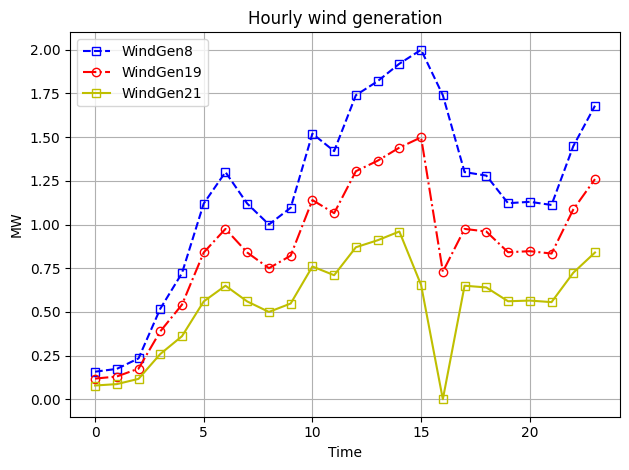

In [44]:
fig, axs = plt.subplots(1, 1)

axs.plot([value(model.Pw[1,j]) for j in range(1,25)], "b--s", markerfacecolor='none', label="WindGen8")
axs.plot([value(model.Pw[2,j]) for j in range(1,25)], "r-.o", markerfacecolor='none', label="WindGen19")
axs.plot([value(model.Pw[3,j]) for j in range(1,25)], "y-s", markerfacecolor='none', label="WindGen21")

axs.grid(True)
axs.set_xlabel("Time")
axs.set_ylabel("MW")
axs.set_title("Hourly wind generation")
axs.legend()

fig.tight_layout()
plt.show()